In [29]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [30]:
df = pd.read_csv("abalone.csv")

In [31]:
df.head().append(df.tail())

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10
4176,M,0.710,0.555,0.195,1.9485,0.9455,0.3765,0.4950,12


In [32]:
df.shape

(4177, 9)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [34]:
# look the distribution of abalone sex
# sex's datatype is string

df['Sex'].value_counts()

M    1528
I    1342
F    1307
Name: Sex, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='count'>

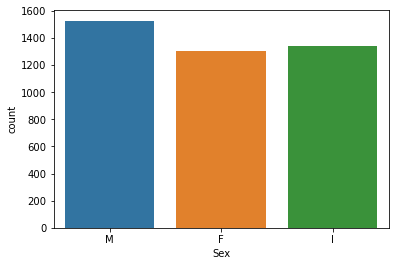

In [35]:
sns.countplot(x='Sex', data=df)

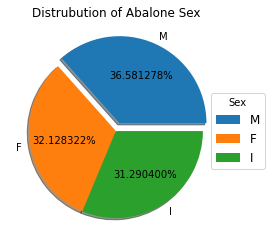

In [36]:
n = len(df['Sex'].unique())
labels = [df['Sex'].unique()[i] for i in range(n)]
fraces = [df['Sex'].value_counts()[i] for i in range(n)]
explode = [0.1, 0, 0]

plt.title("Distrubution of Abalone Sex")
wedges, texts, autotexts = plt.pie(x=fraces, labels=labels, autopct='%0f%%',
        explode=explode,shadow=True)
plt.legend(wedges, labels, fontsize=12, title="Sex",
          loc="center left", bbox_to_anchor=(0.91, 0, 0.3, 1))

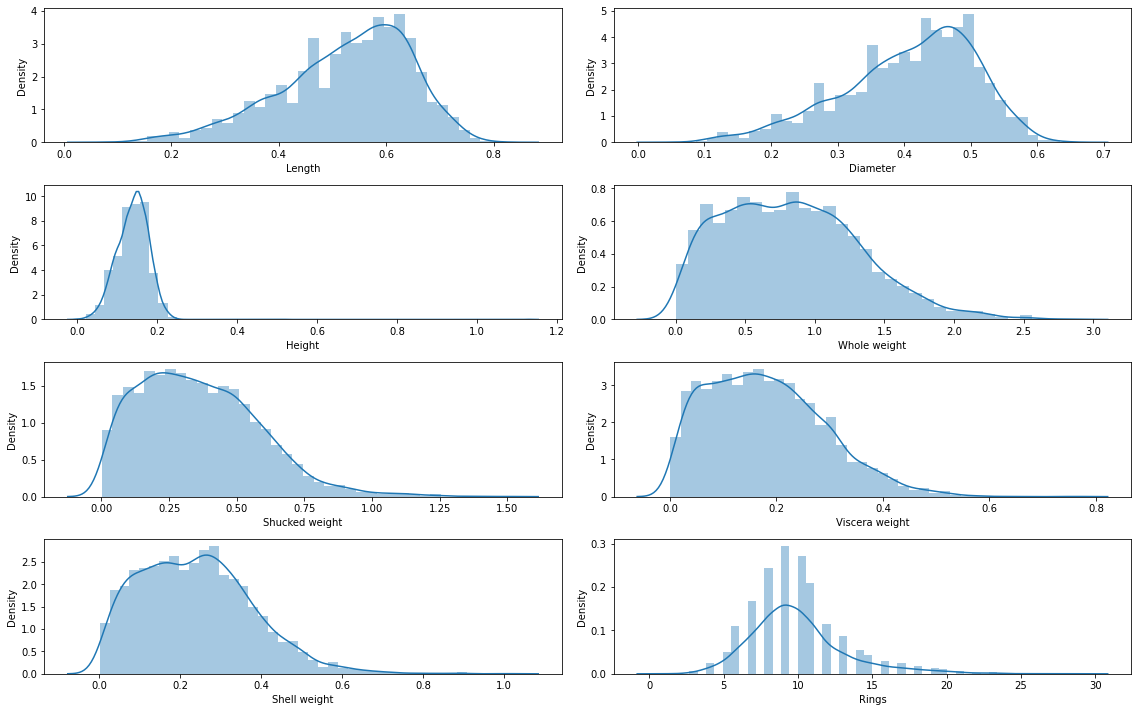

In [37]:
# other attributes are continuous, so using the distplot
i=1
plt.figure(figsize=(16,10))
for col in df.columns[1:]:
    plt.subplot(4,2,i)
    i=i+1
    sns.distplot(df[col])
plt.tight_layout()

# Regression with Tensorflow

In [38]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

from sklearn.utils import shuffle

In [39]:
# sex label is object type(value:'M','F','I'), which is not suitable for regression
# so convert this into numerical type

size_mapping = {
    'F': 0.1,
    'M': 0.5,
    'I': 0.9
}
df['Sex'] = df['Sex'].map(size_mapping)

In [40]:
df.dtypes

Sex               float64
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object

In [41]:
# data normalization
data = np.array(df.values)
n = len(df.columns)
for i in range(n-1):
    data[:,i] = data[:,i]/(data[:,i].max() - data[:,i].min())

In [45]:
# x: input features, y: prediction data
x_data = data[:,:n-1]
y_data = data[:,-1]

train_epochs = 50
learning_rate = 0.01

# x: placeholders of features data, y: placeholders of label data
x = tf.placeholder(tf.float32, [None, n-1], name='x')
y = tf.placeholder(tf.float32, [None, 1], name='y')

In [46]:
# define 8-variavles model: Y = w1*X1 + w2*X2 + w3*X3 + w4*X4 + w5*X5 + w6*X6 + w7*X7 + w8*X8 + bias
with tf.name_scope("model"):
    w = tf.Variable(tf.random_normal([n-1, 1], stddev = 0.01), name = "w")
    b = tf.Variable(1.0, name = "b")
    def model(x, w, b):
        return tf.matmul(x, w) + b
    pred = model(x, w, b)

# define loss function using the mean square error
with tf.name_scope("LossFunction"):
    loss_function = tf.reduce_mean(tf.pow(y-pred, 2))

In [47]:
# optimizer using the algorithm of random gradient descent 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_function)

sess= tf.compat.v1.Session()
init = tf.global_variables_initializer()

sum_loss_op = tf.summary.scalar("loss", loss_function)
 
merged = tf.summary.merge_all()
 
sess.run(init)

In [48]:
loss_list = []
loss_list2 = []
for epoch in range(train_epochs):
    loss_sum = 0.0
    for xs,ys in zip(x_data, y_data):
        xs = xs.reshape(1, n-1)
        ys = ys.reshape(1, 1)
        
        _, summary_str, loss = sess.run([optimizer, sum_loss_op, loss_function], feed_dict = {x:xs, y:ys})
        
        loss_sum = loss_sum + loss
        
        loss_list2.append(loss)
        
    xvalues, yvalues = shuffle(x_data, y_data)
    
    b0temp = b.eval(session=sess)
    w0temp = w.eval(session=sess)
    loss_average = loss_sum/len(y_data)
    
    loss_list.append(loss_average)
    
    print("epoch=", epoch+1, "loss=", loss_average, "b=", b0temp, "w=", w0temp)

epoch= 1 loss= 4.265856462939544 b= 3.2832737 w= [[ 0.07967953]
 [ 3.1323745 ]
 [ 3.1326654 ]
 [ 0.77663815]
 [ 1.6204977 ]
 [-0.03952751]
 [ 0.41734457]
 [ 2.9667907 ]]
epoch= 2 loss= 3.7887537773908395 b= 2.9675274 w= [[ 0.1159331 ]
 [ 3.4000642 ]
 [ 3.3950198 ]
 [ 1.0388315 ]
 [ 1.6900821 ]
 [-1.090624  ]
 [-0.29923445]
 [ 4.292864  ]]
epoch= 3 loss= 3.712543486849836 b= 2.7698212 w= [[ 0.11967879]
 [ 3.6020036 ]
 [ 3.5729005 ]
 [ 1.2777222 ]
 [ 1.767573  ]
 [-2.0037742 ]
 [-0.9181846 ]
 [ 5.410724  ]]
epoch= 4 loss= 3.6586404542288142 b= 2.6293898 w= [[ 0.1193572]
 [ 3.7555645]
 [ 3.6889524]
 [ 1.4974462]
 [ 1.8678844]
 [-2.787075 ]
 [-1.4420033]
 [ 6.365694 ]]
epoch= 5 loss= 3.6198369809054913 b= 2.528878 w= [[ 0.1179923]
 [ 3.8733683]
 [ 3.7586846]
 [ 1.7007319]
 [ 1.9860705]
 [-3.460901 ]
 [-1.8859737]
 [ 7.1815214]]
epoch= 6 loss= 3.591670649037507 b= 2.4577956 w= [[ 0.11612771]
 [ 3.964893  ]
 [ 3.793788  ]
 [ 1.8897638 ]
 [ 2.1168842 ]
 [-4.0432105 ]
 [-2.2637987 ]
 [ 7.87730

epoch= 50 loss= 3.48742906064279 b= 2.3194976 w= [[ 0.08550634]
 [ 5.1722226 ]
 [ 2.3418121 ]
 [ 5.446829  ]
 [ 7.369135  ]
 [-9.799145  ]
 [-5.575802  ]
 [10.296855  ]]


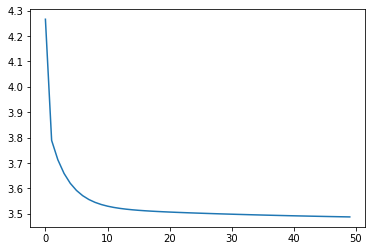

In [49]:
# the change of loss function

plt.plot(loss_list)

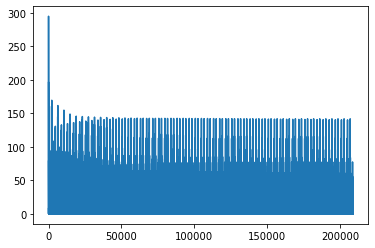

In [50]:
plt.plot(loss_list2)